# Confidence Funnel — Pipeline Health Dashboard

Diagnostic view of the 8-gate high-confidence funnel, Phase 0 exclusion
breakdown, and warning histograms across the full synthetic corpus.

**Purpose**: Health check to run after each corpus rebuild — not a thesis figure.
Verify that gates behave as expected, no invariant violations, and
quality-weight bounds hold.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, str(Path("../../..").resolve()))
from data.loader import load_ghidra_dataset

# ── Config ────────────────────────────────────────────────────────────
SELECTED_TESTS = None   # None = all
OPT_LEVELS = ["O0", "O1", "O2", "O3"]

THESIS_RC = {
    "font.family": "serif", "font.size": 10,
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9, "figure.dpi": 120,
    "savefig.dpi": 300, "savefig.bbox": "tight",
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False, "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)

OPT_COLORS = {"O0": "#4daf4a", "O1": "#377eb8", "O2": "#ff7f00", "O3": "#e41a1c"}

FIG_DIR = Path("../../../figures/join_health")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name, fig=None):
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  -> saved {FIG_DIR / name}.{{pdf,png}}")

# ── Load ──────────────────────────────────────────────────────────────
gds = load_ghidra_dataset(test_cases=SELECTED_TESTS, opt_levels=OPT_LEVELS)
df = gds.functions
dr = gds.reports
print(f"Loaded {len(df)} functions across {len(dr)} (test_case, opt) cells")

Loaded 1792 functions across 60 (test_case, opt) cells


---
## 1. Aggregate Confidence Funnel (waterfall)

The 8-gate funnel filters gold-eligible functions down to high-confidence (HC).
Each bar shows the cumulative surviving count; annotations show the drop at each gate.

  -> saved ..\..\..\figures\join_health\confidence_funnel_aggregate.{pdf,png}


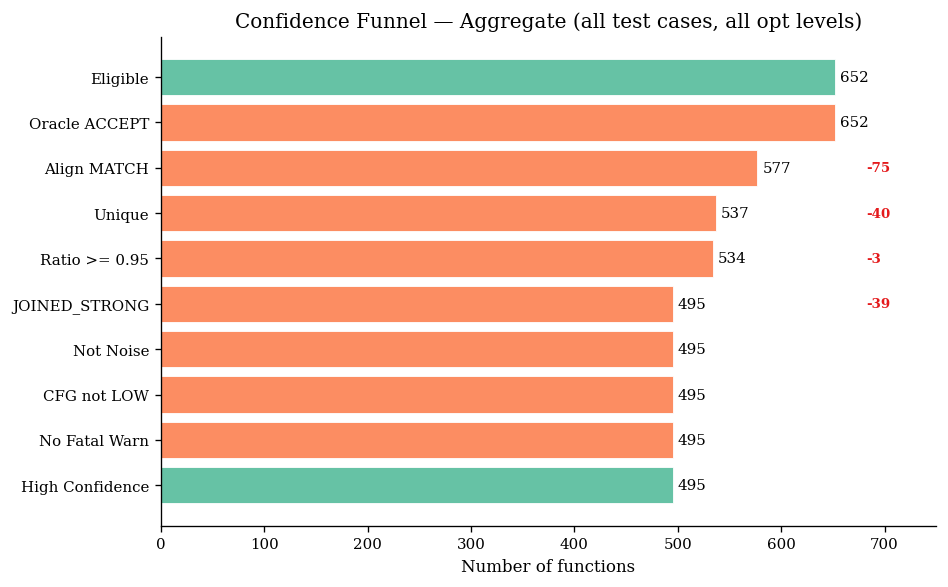

In [2]:
GATE_COLS = [
    ("funnel_n_eligible_for_gold",   "Eligible"),
    ("funnel_n_pass_oracle_accept",  "Oracle ACCEPT"),
    ("funnel_n_pass_align_match",    "Align MATCH"),
    ("funnel_n_pass_align_unique",   "Unique"),
    ("funnel_n_pass_align_ratio",    "Ratio >= 0.95"),
    ("funnel_n_pass_joined_strong",  "JOINED_STRONG"),
    ("funnel_n_pass_not_noise",      "Not Noise"),
    ("funnel_n_pass_cfg_not_low",    "CFG not LOW"),
    ("funnel_n_pass_no_fatal_warnings", "No Fatal Warn"),
    ("funnel_n_high_confidence",     "High Confidence"),
]

# Aggregate across all reports
agg = {label: int(dr[col].sum()) for col, label in GATE_COLS}
labels = list(agg.keys())
values = list(agg.values())

fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#66c2a5" if i == 0 or i == len(values) - 1 else "#fc8d62" for i in range(len(values))]
bars = ax.barh(labels[::-1], values[::-1], color=colors[::-1], edgecolor="white", linewidth=0.5)

# Annotate counts and drops
for i, (bar, val) in enumerate(zip(bars, values[::-1])):
    ax.text(val + 5, bar.get_y() + bar.get_height() / 2,
            str(val), va="center", fontsize=9)

# Add drop annotations on the right margin
for i in range(1, len(values)):
    drop = values[i - 1] - values[i]
    if drop > 0:
        idx = len(values) - 1 - i
        ax.text(values[0] + 30, bars[idx].get_y() + bars[idx].get_height() / 2,
                f"-{drop}", va="center", fontsize=8, color="#e41a1c", fontweight="bold")

ax.set_xlabel("Number of functions")
ax.set_title("Confidence Funnel — Aggregate (all test cases, all opt levels)")
ax.set_xlim(0, values[0] * 1.15)
plt.tight_layout()
save_fig("confidence_funnel_aggregate")
plt.show()

---
## 2. Funnel by Optimization Level

Grouped bars showing how each gate behaves per opt level.
Higher optimization is expected to lose more functions at Align MATCH and JOINED_STRONG gates.

  -> saved ..\..\..\figures\join_health\confidence_funnel_by_opt.{pdf,png}


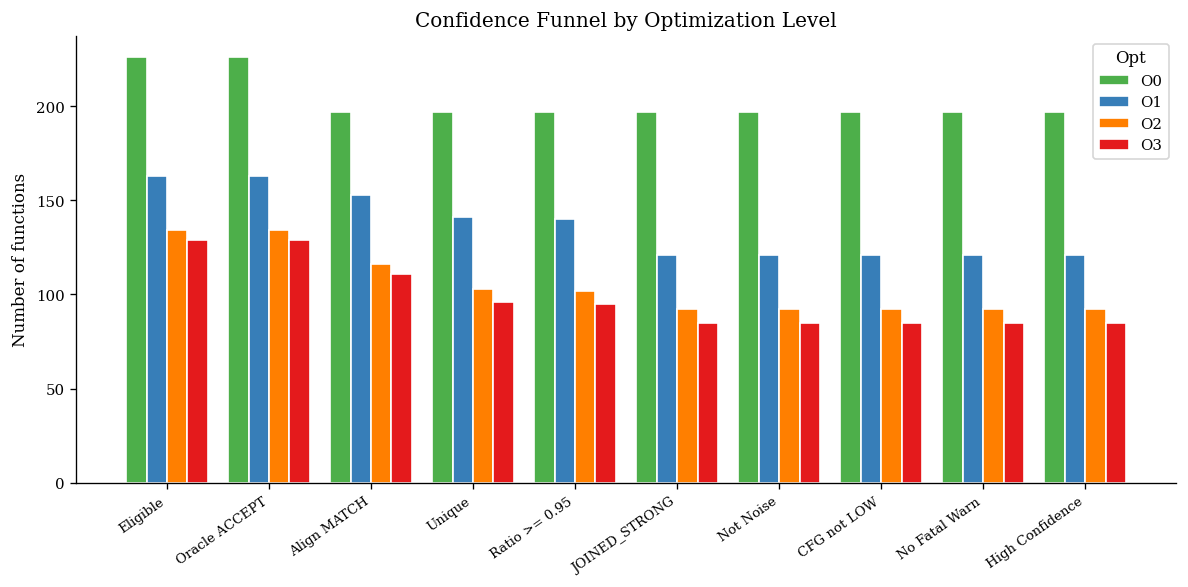

In [3]:
gate_labels = [label for _, label in GATE_COLS]

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(gate_labels))
width = 0.2

for i, opt in enumerate(OPT_LEVELS):
    opt_dr = dr[dr["opt"] == opt]
    vals = [int(opt_dr[col].sum()) for col, _ in GATE_COLS]
    ax.bar(x + i * width, vals, width, label=opt, color=OPT_COLORS[opt], edgecolor="white")

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(gate_labels, rotation=35, ha="right", fontsize=8)
ax.set_ylabel("Number of functions")
ax.set_title("Confidence Funnel by Optimization Level")
ax.legend(title="Opt")
plt.tight_layout()
save_fig("confidence_funnel_by_opt")
plt.show()

---
## 3. Phase 0 Exclusion Breakdown

How many DWARF functions are excluded before they even reach the join?
Stacked bar per opt level showing exclusion categories as fractions of total DWARF functions.

  -> saved ..\..\..\figures\join_health\exclusion_breakdown.{pdf,png}


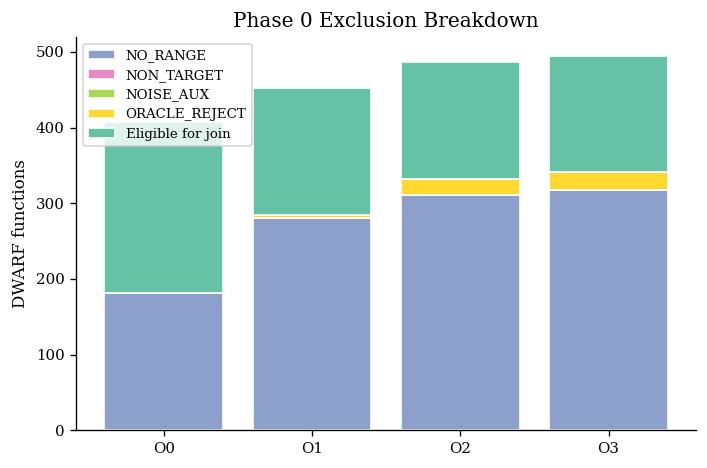

In [4]:
excl_cats = [
    ("excl_n_no_range",     "NO_RANGE",      "#8da0cb"),
    ("excl_n_non_target",   "NON_TARGET",     "#e78ac3"),
    ("excl_n_noise_aux",    "NOISE_AUX",      "#a6d854"),
    ("excl_n_oracle_reject","ORACLE_REJECT",  "#ffd92f"),
]

fig, ax = plt.subplots(figsize=(6, 4))

by_opt = dr.groupby("opt").sum(numeric_only=True)
bottoms = np.zeros(len(OPT_LEVELS))

for col, label, color in excl_cats:
    vals = [by_opt.loc[opt, col] if opt in by_opt.index else 0 for opt in OPT_LEVELS]
    ax.bar(OPT_LEVELS, vals, bottom=bottoms, label=label, color=color, edgecolor="white") #type: ignore
    bottoms += vals #type: ignore

# Add eligible on top
elig_vals = [by_opt.loc[opt, "excl_n_eligible_for_join"] if opt in by_opt.index else 0 for opt in OPT_LEVELS]
ax.bar(OPT_LEVELS, elig_vals, bottom=bottoms, label="Eligible for join", color="#66c2a5", edgecolor="white") #type: ignore

ax.set_ylabel("DWARF functions")
ax.set_title("Phase 0 Exclusion Breakdown")
ax.legend(loc="upper left", fontsize=8)
plt.tight_layout()
save_fig("exclusion_breakdown")
plt.show()

---
## 4. Warning Histograms

Aggregate join warnings and decompiler warnings across all reports.

In [5]:
# Join warnings
jw_cols = [c for c in dr.columns if c.startswith("jw_")]
if jw_cols:
    jw_agg = dr[jw_cols].sum().sort_values(ascending=False)
    jw_agg.index = [c.replace("jw_", "") for c in jw_agg.index]
    print("=== Join Warning Histogram ===")
    display(jw_agg.to_frame("count"))

# Decompiler warnings
dw_cols = [c for c in dr.columns if c.startswith("dec_warn_")]
if dw_cols:
    dw_agg = dr[dw_cols].sum().sort_values(ascending=False)
    dw_agg.index = [c.replace("dec_warn_", "") for c in dw_agg.index]
    print("\n=== Decompiler Warning Histogram ===")
    display(dw_agg.to_frame("count"))

=== Join Warning Histogram ===


,count
DWARF_RANGE_MISSING,1090
NO_GHIDRA_OVERLAP,9



=== Decompiler Warning Histogram ===


,count
DECOMPILER_INTERNAL_WARNING,59.0
INLINE_LIKELY,8.0


---
## 5. Quality-Weight Audit & Invariant Check

Verify all `quality_weight` values are in `[0, 1]` and no invariant violations were recorded.

In [6]:
qa_gt1 = int(dr["qa_n_qw_gt_1"].sum()) if "qa_n_qw_gt_1" in dr.columns else 0 
qa_lt0 = int(dr["qa_n_qw_lt_0"].sum()) if "qa_n_qw_lt_0" in dr.columns else 0
n_violations = int(dr["n_invariant_violations"].sum()) if "n_invariant_violations" in dr.columns else 0

print(f"Quality-weight > 1.0:  {qa_gt1}  {'PASS' if qa_gt1 == 0 else 'FAIL'}")
print(f"Quality-weight < 0.0:  {qa_lt0}  {'PASS' if qa_lt0 == 0 else 'FAIL'}")
print(f"Invariant violations:  {n_violations}  {'PASS' if n_violations == 0 else 'FAIL'}")
print()

# Per-test-case summary
summary = dr.groupby("opt").agg(
    n_cells=("test_case", "count"),
    total_dwarf=("excl_n_total_dwarf", "sum"),
    eligible_gold=("excl_n_eligible_for_gold", "sum"),
    hc_count=("hc_count", "sum"),
).astype(int)
summary["hc_rate"] = (summary["hc_count"] / summary["eligible_gold"] * 100).round(1)
display(summary)

Quality-weight > 1.0:  0  PASS
Quality-weight < 0.0:  0  PASS
Invariant violations:  0  PASS



,n_cells,total_dwarf,eligible_gold,hc_count,hc_rate
opt,,,,,
O0,15,407,226,197,87.2
O1,15,448,163,121,74.2
O2,15,466,134,92,68.7
O3,15,471,129,85,65.9
